## Capital Asset Pricing Model

이번 시간에는 CAPM 모형에 대해서 실습을 진행한다

### 1. Data Import

yfinance 혹은 pandas datareader를 통해 주가 데이터를 불러온다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web

data = pd.DataFrame()
for code in ['005930', '000660', '035720', '035420'] :
    data = pd.concat([data, web.DataReader(code, 'naver', start = '2020-01-01', end = '2021-01-01')['Close'].apply(int)], axis = 1)

data.columns = ['Samsung', 'Hynics', 'Kakao', 'Naver']
noa = len(data.columns)
data

,Samsung,Hynics,Kakao,Naver
2020-01-02,55200,94700,30609,182500
2020-01-03,55500,94500,30609,181500
2020-01-06,55500,94300,31010,180500
2020-01-07,55800,94000,32114,187000
2020-01-08,56800,97400,32014,183000
...,...,...,...,...
2020-12-23,73900,116000,75770,284000
2020-12-24,77800,118000,75068,282000
2020-12-28,78700,115500,74867,281000
2020-12-29,78300,116000,77175,283000


<AxesSubplot:>

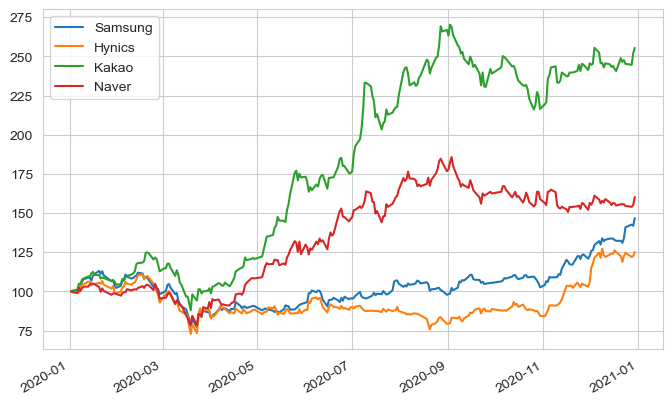

In [2]:
# Normalized Plot
(data / data.iloc[0] * 100).plot(figsize=(8, 5))

model 분석을 위해 수익률을 계산해 준다

In [3]:
ret = (np.log(data) - np.log(data.shift())).dropna()
ret

,Samsung,Hynics,Kakao,Naver
2020-01-03,0.005420,-0.002114,0.000000,-0.005495
2020-01-06,0.000000,-0.002119,0.013016,-0.005525
2020-01-07,0.005391,-0.003186,0.034982,0.035378
2020-01-08,0.017762,0.035531,-0.003119,-0.021622
2020-01-09,0.031198,0.016294,0.027816,0.016261
...,...,...,...,...
2020-12-23,0.021889,0.030637,0.003980,0.000000
2020-12-24,0.051429,0.017094,-0.009308,-0.007067
2020-12-28,0.011502,-0.021414,-0.002681,-0.003552
2020-12-29,-0.005096,0.004320,0.030362,0.007092


### 2. Random Portfolio

가중치 계산을 위해 random portfolio를 계산한다

In [4]:
weights = np.random.random(noa)
weights /= sum(weights)

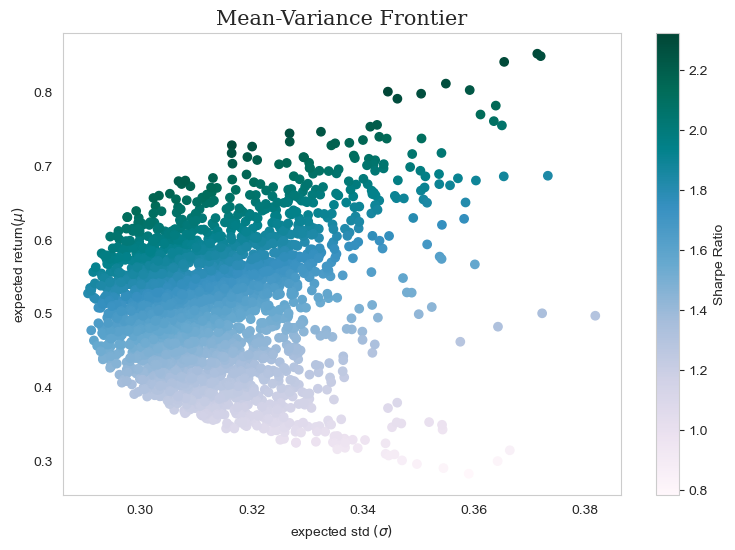

In [5]:
port_rets = []
port_std = []

def ret_std(weight, ret, period = 245):
    port_mean = np.sum(weight * ret.mean() * period) # sample mean
    port_var = np.dot(weight.T, np.dot(ret.cov() * period, weight)) # sample variance
    port_std = np.sqrt(port_var) # sample standard deviation
    return port_mean, port_std

for w in range(2500):
    weight = np.random.random(noa)
    weight /= np.sum(weight)
    mu, sig = ret_std(weight, ret, period = 247)
    port_rets.append(mu)
    port_std.append(sig)

sr = np.array(port_rets)/np.array(port_std) # sharpe ratio

plt.figure(figsize = (9,6))
plt.scatter(port_std, port_rets, c = sr, marker = 'o',  cmap = 'PuBuGn')
plt.colorbar(label = 'Sharpe Ratio')
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.title('Mean-Variance Frontier', fontsize = 15, fontfamily = 'Serif')
plt.grid()

### 3. Optimization
#### 3.1 Optimization 1: weights maximizing the Sharpe ratio
$$\max_{w_i's} (\mathrm{Sharpe ~ Ratio})\equiv \frac{r_p-r_f}{\sigma_p} ~~~~ \mbox{such that }  ~~~~ \sum_{i=1}^N w_i =1 , 0 \le w_i \le 1$$

Sharpe Ratio를 극대화하는 최적화 점을 찾아낼 수 있다

In [6]:
import scipy.optimize as opt

def statistics(weights, rf = 0, period = 246):
    weights = np.array(weights)
    pret = np.sum(ret.mean() * weights) * period - rf
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * period, weights)))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights, rf = 0):
    return -statistics(weights, rf = rf, period = 247)[2]

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method = 'SLSQP',
                    bounds = bnds, constraints = cons)
opts

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.3639411674583557
       x: [ 1.853e-01  1.116e-16  8.147e-01  0.000e+00]
     nit: 7
     jac: [ 4.154e-05  6.296e-01 -9.418e-06  7.369e-01]
    nfev: 35
    njev: 7

In [7]:
opts.x.round(3)

array([0.185, 0.   , 0.815, 0.   ])

In [8]:
statistics(opts['x']).round(3)

array([0.832, 0.353, 2.359])

#### 3.2 Optimization 2: weights minimizing variance (volatility)

아래의 제약식을 계산하면 mean-variance 평면에서 분산이 가장 작은 지점을 찾아낼 수 있다

$$\min_{w_i's} \sigma_p^2 ~~~~ \mbox{such that }  ~~~~ \sum_{i=1}^N w_i =1 , 0 \le w_i \le 1$$

In [9]:
def min_func_volatility(weights):
    return statistics(weights, period = 247)[1] ** 2

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
optv = opt.minimize(min_func_volatility, noa * [1. / noa,], method = 'SLSQP',
                    bounds = bnds, constraints = cons)

In [10]:
optv.x.round(3)

array([0.609, 0.   , 0.212, 0.179])

In [11]:
statistics(optv['x']).round(3)

array([0.515, 0.29 , 1.778])

#### 3.3 Optimization 3: Optimal Portfolio Frontier

아래의 제약식을 충족하는 최소분산의 frontier를 계산하자

$$\min_{w_i's} \sigma_p^2 ~~~~ \mbox{such that }  ~~~~ \sum_{i=1}^N w_i =1 , 0 \le w_i \le 1,   r_p = \bar{r}$$

In [12]:
def min_func_port(weights):
    return statistics(weights)[1]

cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = opt.minimize(min_func_port, noa * [1. / noa,], method = 'SLSQP',
                       bounds = bnds, constraints = cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

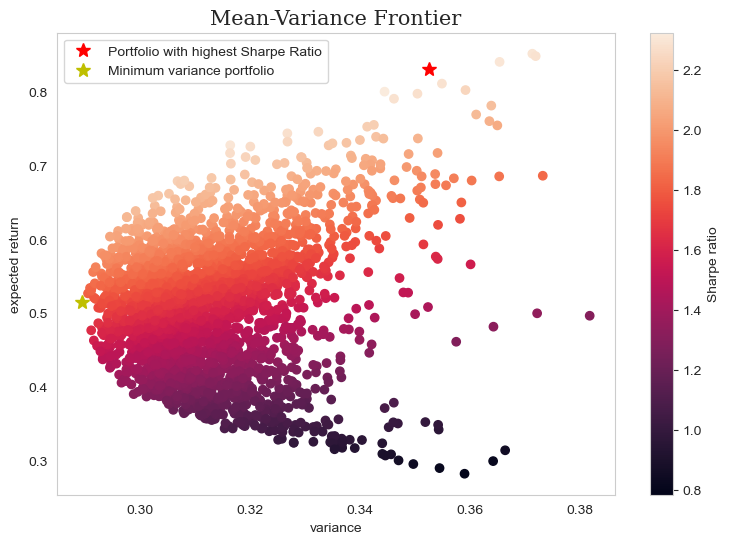

In [13]:
plt.figure(figsize = (9, 6))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker = 'o')
            # random portfolio composition=
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize = 10.0, label = 'Portfolio with highest Sharpe Ratio')
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize = 10.0, label = 'Minimum variance portfolio')
            # minimum variance portfolio
plt.legend()
plt.grid(False)
plt.xlabel('variance', fontsize = 10)
plt.ylabel('expected return', fontsize = 10)
plt.colorbar(label = 'Sharpe ratio')
plt.title('Mean-Variance Frontier', fontsize = 15, fontfamily = 'Serif')
plt.show()

### 4. Capital Market Line

자본시장선(CML)은 무위험자산이 존재할 경우의 효율적 투자선을 의미한다. 마코비츠의 포트폴리오 이론에서 도출된 위험자산만으로 구성되었던 효율적포트폴리오에 무위험자산을 포함하여 새로운 포트폴리오를 만들 수 있다. 이러한 새로운 포트폴리오집합을 자본배분선(CAL)이라고 하며, 이중에서 지배원리를 만족시키는 CAL을 자본시장선이라고 한다.

$$\mbox{CML} : E(R_p) = R_f + σ_p \frac{E(R_M) - R_f}{\sigma_M}$$

CML은 CAPM모형에서 Sharpe Ratio가 가장 높은 최적점과 무위험자산(risk free asset)의 수익률을 y-intercept로 지나는 직선으로 표현 가능하다

In [14]:
rf = 0.035
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
var_list = [x * slope + rf for x in np.linspace(0.28, 0.40, 2500)]

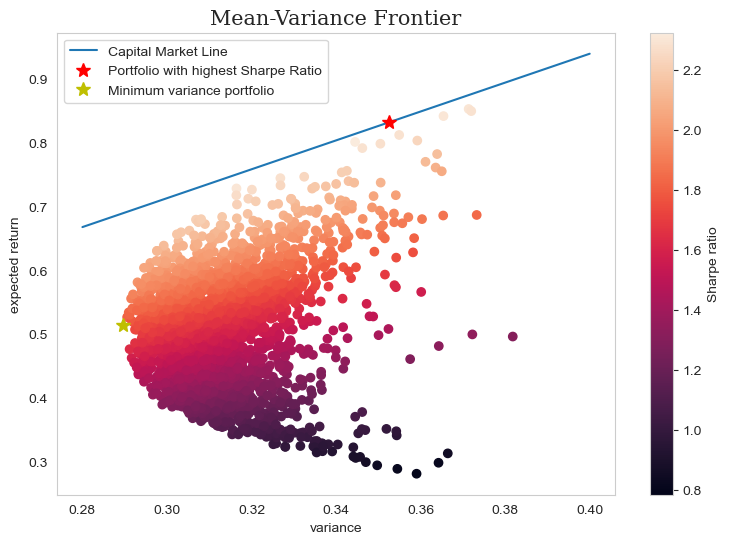

In [15]:
x =  np.linspace(0.28, 0.40, 2500)
y = var_list

plt.figure(figsize = (9, 6))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker = 'o')
plt.plot(x, y, label = 'Capital Market Line')
            # random portfolio composition
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize = 10, label = 'Portfolio with highest Sharpe Ratio')
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize = 10, label = 'Minimum variance portfolio')
plt.legend()
plt.grid(False)
plt.xlabel('variance', fontsize = 10)
plt.ylabel('expected return', fontsize = 10)
plt.colorbar(label = 'Sharpe ratio')
plt.title('Mean-Variance Frontier', fontsize = 15, fontfamily = 'Serif')
plt.show()